# AI Quadrant Analysis - Patient Journey Visualization

This notebook demonstrates the AI Quadrant visualization feature that provides transparency into ML prediction performance by analyzing patient journeys and categorizing outcomes into True Positives, False Positives, True Negatives, and False Negatives.

## Overview

The AI Quadrant approach visualizes patients based on two key dimensions:
1. **True Risk**: The actual underlying risk level of the patient
2. **AI Prediction**: The score predicted by the machine learning model

This creates four quadrants:
- **High Priority**: High risk + AI flagged → Should intervene
- **Missed Opportunities**: High risk + AI missed → AI failed to identify
- **False Alarms**: Low risk + AI flagged → Unnecessary interventions
- **Correct Rejections**: Low risk + AI correct → Correctly identified as low risk

## Key Features

1. **Patient Journey Visualization**: 8-panel comprehensive analysis for individual patients
2. **Quadrant Analysis**: Population-level analysis grouped by prediction outcomes
3. **Clinical Metrics**: NNT, resource utilization, and intervention effectiveness
4. **Temporal Patterns**: How risk evolves over time for each quadrant
5. **Interactive Analysis**: Tools for exploring different scenarios

## Setup and Data Generation

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
import sys
import os

# Add src directory to path for imports
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

# Import functions from our modules
from pop_ml_simulator import (
    # Core simulation functions
    assign_patient_risks,
    build_temporal_risk_matrix,
    integrate_window_risk,
    extract_risk_windows,
    
    # ML simulation functions
    generate_temporal_ml_predictions,
    MLPredictionSimulator,
    
    # New AI Quadrant functions
    analyze_patient_journey_enhanced,
    analyze_patients_by_outcome,
    plot_ai_quadrant,
    
    # Evaluation functions
    evaluate_threshold_based
)

# Import generate_temporal_events directly from ml_simulation module
from pop_ml_simulator.ml_simulation import generate_temporal_events

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Setup complete! Ready for AI Quadrant analysis...")

✅ Setup complete! Ready for AI Quadrant analysis...


## Data Generation

Let's generate a realistic patient population with temporal risk dynamics and ML predictions.

In [31]:
# Generate patient population
n_patients = 2000  # Manageable size for detailed analysis
n_timesteps = 52   # One year of weekly data
annual_incident_rate = 0.12
concentration = 0.4

# Generate base patient risks
print("Generating patient population...")
base_risks = assign_patient_risks(
    n_patients,
    annual_incident_rate=annual_incident_rate,
    concentration=concentration,
    random_seed=42
)

print(f"Patient population: {n_patients:,}")
print(f"Mean base risk: {np.mean(base_risks):.1%}")
print(f"Risk range: [{np.min(base_risks):.3f}, {np.max(base_risks):.3f}]")

# Build temporal risk matrix
print("\nBuilding temporal risk matrix...")
temporal_matrix = build_temporal_risk_matrix(
    base_risks,
    n_timesteps=n_timesteps,
    rho=0.9,  # High temporal correlation
    sigma=0.15,  # Moderate volatility
    temporal_bounds=(0.3, 2.0),
    seasonal_amplitude=0.2,  # 20% seasonal variation
    seasonal_period=52,  # Annual cycle
    random_seed=42
)

print(f"Temporal matrix shape: {temporal_matrix.shape}")
print(f"Temporal risk range: [{np.min(temporal_matrix):.3f}, {np.max(temporal_matrix):.3f}]")

# Define prediction window
prediction_start = 20
window_length = 12

print(f"\nPrediction window: weeks {prediction_start} to {prediction_start + window_length}")

Generating patient population...
Patient population: 2,000
Mean base risk: 12.0%
Risk range: [0.000, 0.926]

Building temporal risk matrix...
Temporal matrix shape: (2000, 52)
Temporal risk range: [0.000, 0.950]

Prediction window: weeks 20 to 32


## Generate ML Predictions and Events

Now we'll generate realistic ML predictions and temporal events using the improved event generation approach.

In [32]:
# Generate ML predictions using temporal approach
print("Generating ML predictions...")
predictions, binary_predictions, ml_metrics = generate_temporal_ml_predictions(
    temporal_matrix,
    prediction_start_time=prediction_start,  # Fixed parameter name
    prediction_window_length=window_length,   # Fixed parameter name
    target_sensitivity=0.75,
    target_ppv=0.25,
    timestep_duration=1/52,
    random_seed=42
)

print(f"\nML Performance Achieved:")
print(f"Sensitivity: {ml_metrics['sensitivity']:.1%}")
print(f"PPV: {ml_metrics['ppv']:.1%}")
print(f"Specificity: {ml_metrics['specificity']:.1%}")
print(f"F1 Score: {ml_metrics['f1']:.3f}")
print(f"Threshold: {ml_metrics['threshold']:.3f}")

# Generate temporal events
print("\nGenerating temporal events...")
event_matrix, event_times = generate_temporal_events(
    temporal_matrix,
    timestep_duration=1/52,
    random_seed=42
)

# Extract labels for the prediction window
window_end = prediction_start + window_length
true_labels = np.zeros(n_patients, dtype=int)

for i in range(n_patients):
    if event_times[i] >= 0:  # Patient has an event
        # Check if event occurs within the prediction window
        if prediction_start <= event_times[i] < window_end:
            true_labels[i] = 1

print(f"Events in prediction window: {np.sum(true_labels)} ({np.mean(true_labels):.1%} prevalence)")
print(f"Total events (full year): {np.sum(event_times >= 0)} ({np.mean(event_times >= 0):.1%})")

# Calculate integrated risks for analysis
print("\nCalculating integrated risks...")
risk_windows = extract_risk_windows(
    temporal_matrix,
    prediction_start,
    window_length
)

integrated_risks = integrate_window_risk(
    risk_windows,
    timestep_duration=1/52
)

print(f"Integrated risks range: [{np.min(integrated_risks):.3f}, {np.max(integrated_risks):.3f}]")
print(f"Mean integrated risk: {np.mean(integrated_risks):.3f}")

Generating ML predictions...

ML Performance Achieved:
Sensitivity: 75.4%
PPV: 9.3%
Specificity: 78.4%
F1 Score: 0.166
Threshold: 0.792

Generating temporal events...
Events in prediction window: 57 (2.9% prevalence)
Total events (full year): 243 (12.2%)

Calculating integrated risks...
Integrated risks range: [0.000, 1.000]
Mean integrated risk: 0.466


## AI Quadrant Visualization

Now let's create the main AI Quadrant visualization that shows how patients are distributed across the four quadrants.

Creating AI Quadrant visualization...


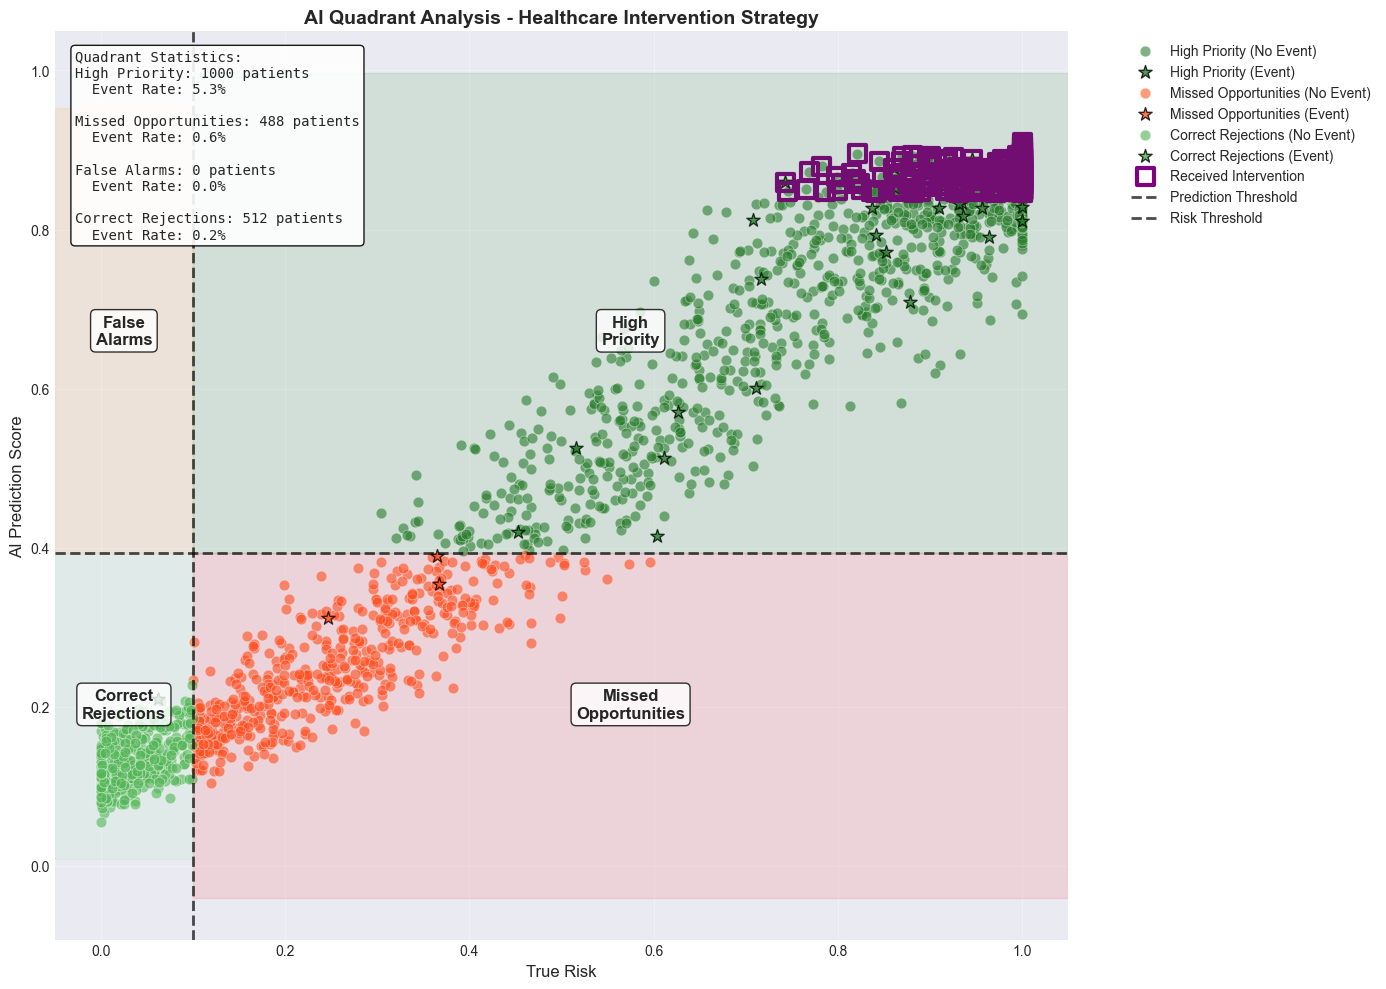


Quadrant Statistics:
high_priority: 1000 patients (50.0%)
  Event rate: 5.3%
  Mean risk: 0.797
  Mean prediction: 0.721

missed_opportunities: 488 patients (24.4%)
  Event rate: 0.6%
  Mean risk: 0.248
  Mean prediction: 0.249

false_alarms: 0 patients (0.0%)
  Event rate: 0.0%
  Mean risk: 0.000
  Mean prediction: 0.000

correct_rejections: 512 patients (25.6%)
  Event rate: 0.2%
  Mean risk: 0.029
  Mean prediction: 0.129



In [33]:
# Create AI Quadrant visualization
print("Creating AI Quadrant visualization...")

# Generate intervention mask (simulate that we intervene on top 10% of predictions)
intervention_threshold = np.percentile(predictions, 90)
intervention_mask = predictions >= intervention_threshold

fig, stats = plot_ai_quadrant(
    true_risks=integrated_risks,
    predictions=predictions,
    true_events=true_labels,
    intervention_mask=intervention_mask,
    risk_threshold=0.1,  # 10% risk threshold
    prediction_threshold=None,  # Use median
    title="AI Quadrant Analysis - Healthcare Intervention Strategy",
    figsize=(14, 10),
    show_stats=True,
    highlight_interventions=True
)

print(f"\nQuadrant Statistics:")
for quadrant, data in stats.items():
    if isinstance(data, dict) and 'count' in data:
        print(f"{quadrant}: {data['count']} patients ({data['count']/stats['overall']['total_patients']*100:.1f}%)")
        print(f"  Event rate: {data['event_rate']:.1%}")
        print(f"  Mean risk: {data['mean_risk']:.3f}")
        print(f"  Mean prediction: {data['mean_prediction']:.3f}")
        print()

## Individual Patient Journey Analysis

Let's examine specific patients from each quadrant to understand their individual journeys.

Analyzing patients by outcome...


/Users/michaeldraugelis/Library/CloudStorage/Dropbox/proj/pop-ml-simulator/src/pop_ml_simulator/ml_simulation.py:2298: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


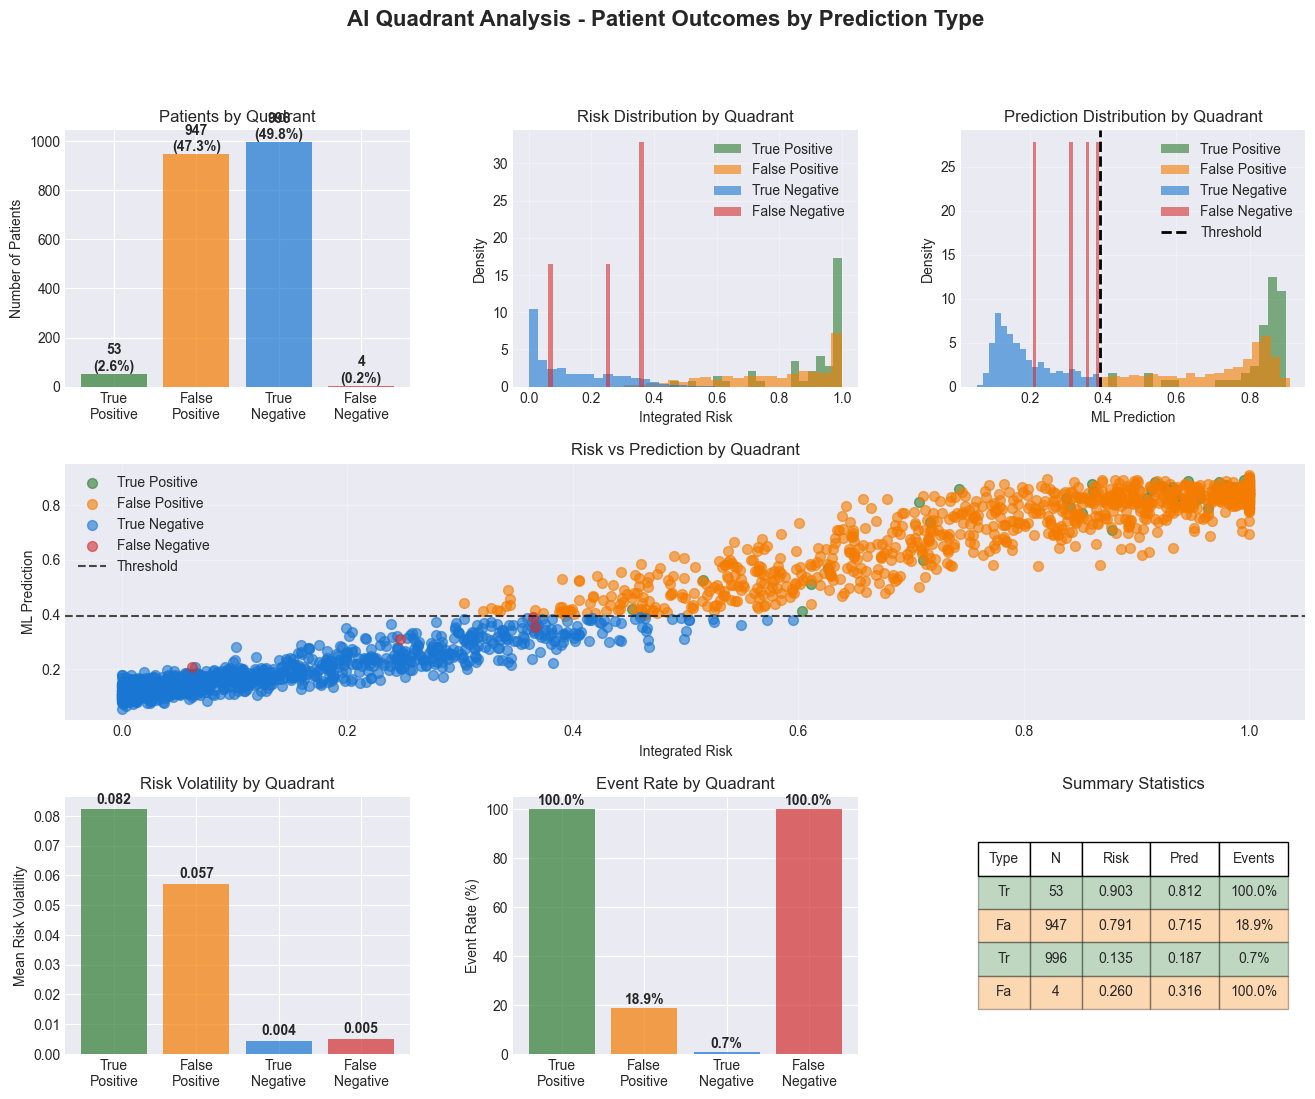


Sample patients selected for detailed analysis:
True Positive: 3 patients - [ 620 1368  221]
False Positive: 3 patients - [ 152  354 1220]
True Negative: 3 patients - [1506  436  311]
False Negative: 3 patients - [1452 1460  658]


In [18]:
# Analyze patients by outcome to get sample patients from each quadrant
print("Analyzing patients by outcome...")
outcome_analysis = analyze_patients_by_outcome(
    temporal_matrix,
    predictions,
    true_labels,
    event_times,
    prediction_start,
    window_length,
    integrated_risks=integrated_risks,
    base_risks=base_risks,
    threshold=stats['thresholds']['prediction_threshold'],
    n_samples_per_quadrant=3
)

print("\nSample patients selected for detailed analysis:")
for quadrant, patient_ids in outcome_analysis['sample_patients'].items():
    print(f"{quadrant}: {len(patient_ids)} patients - {patient_ids[:5]}")

### True Positive Patient Analysis

Let's examine a True Positive patient - one who was correctly identified as high risk by the AI and actually had an event.

Analyzing True Positive Patient 620...


/Users/michaeldraugelis/Library/CloudStorage/Dropbox/proj/pop-ml-simulator/src/pop_ml_simulator/ml_simulation.py:1657: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


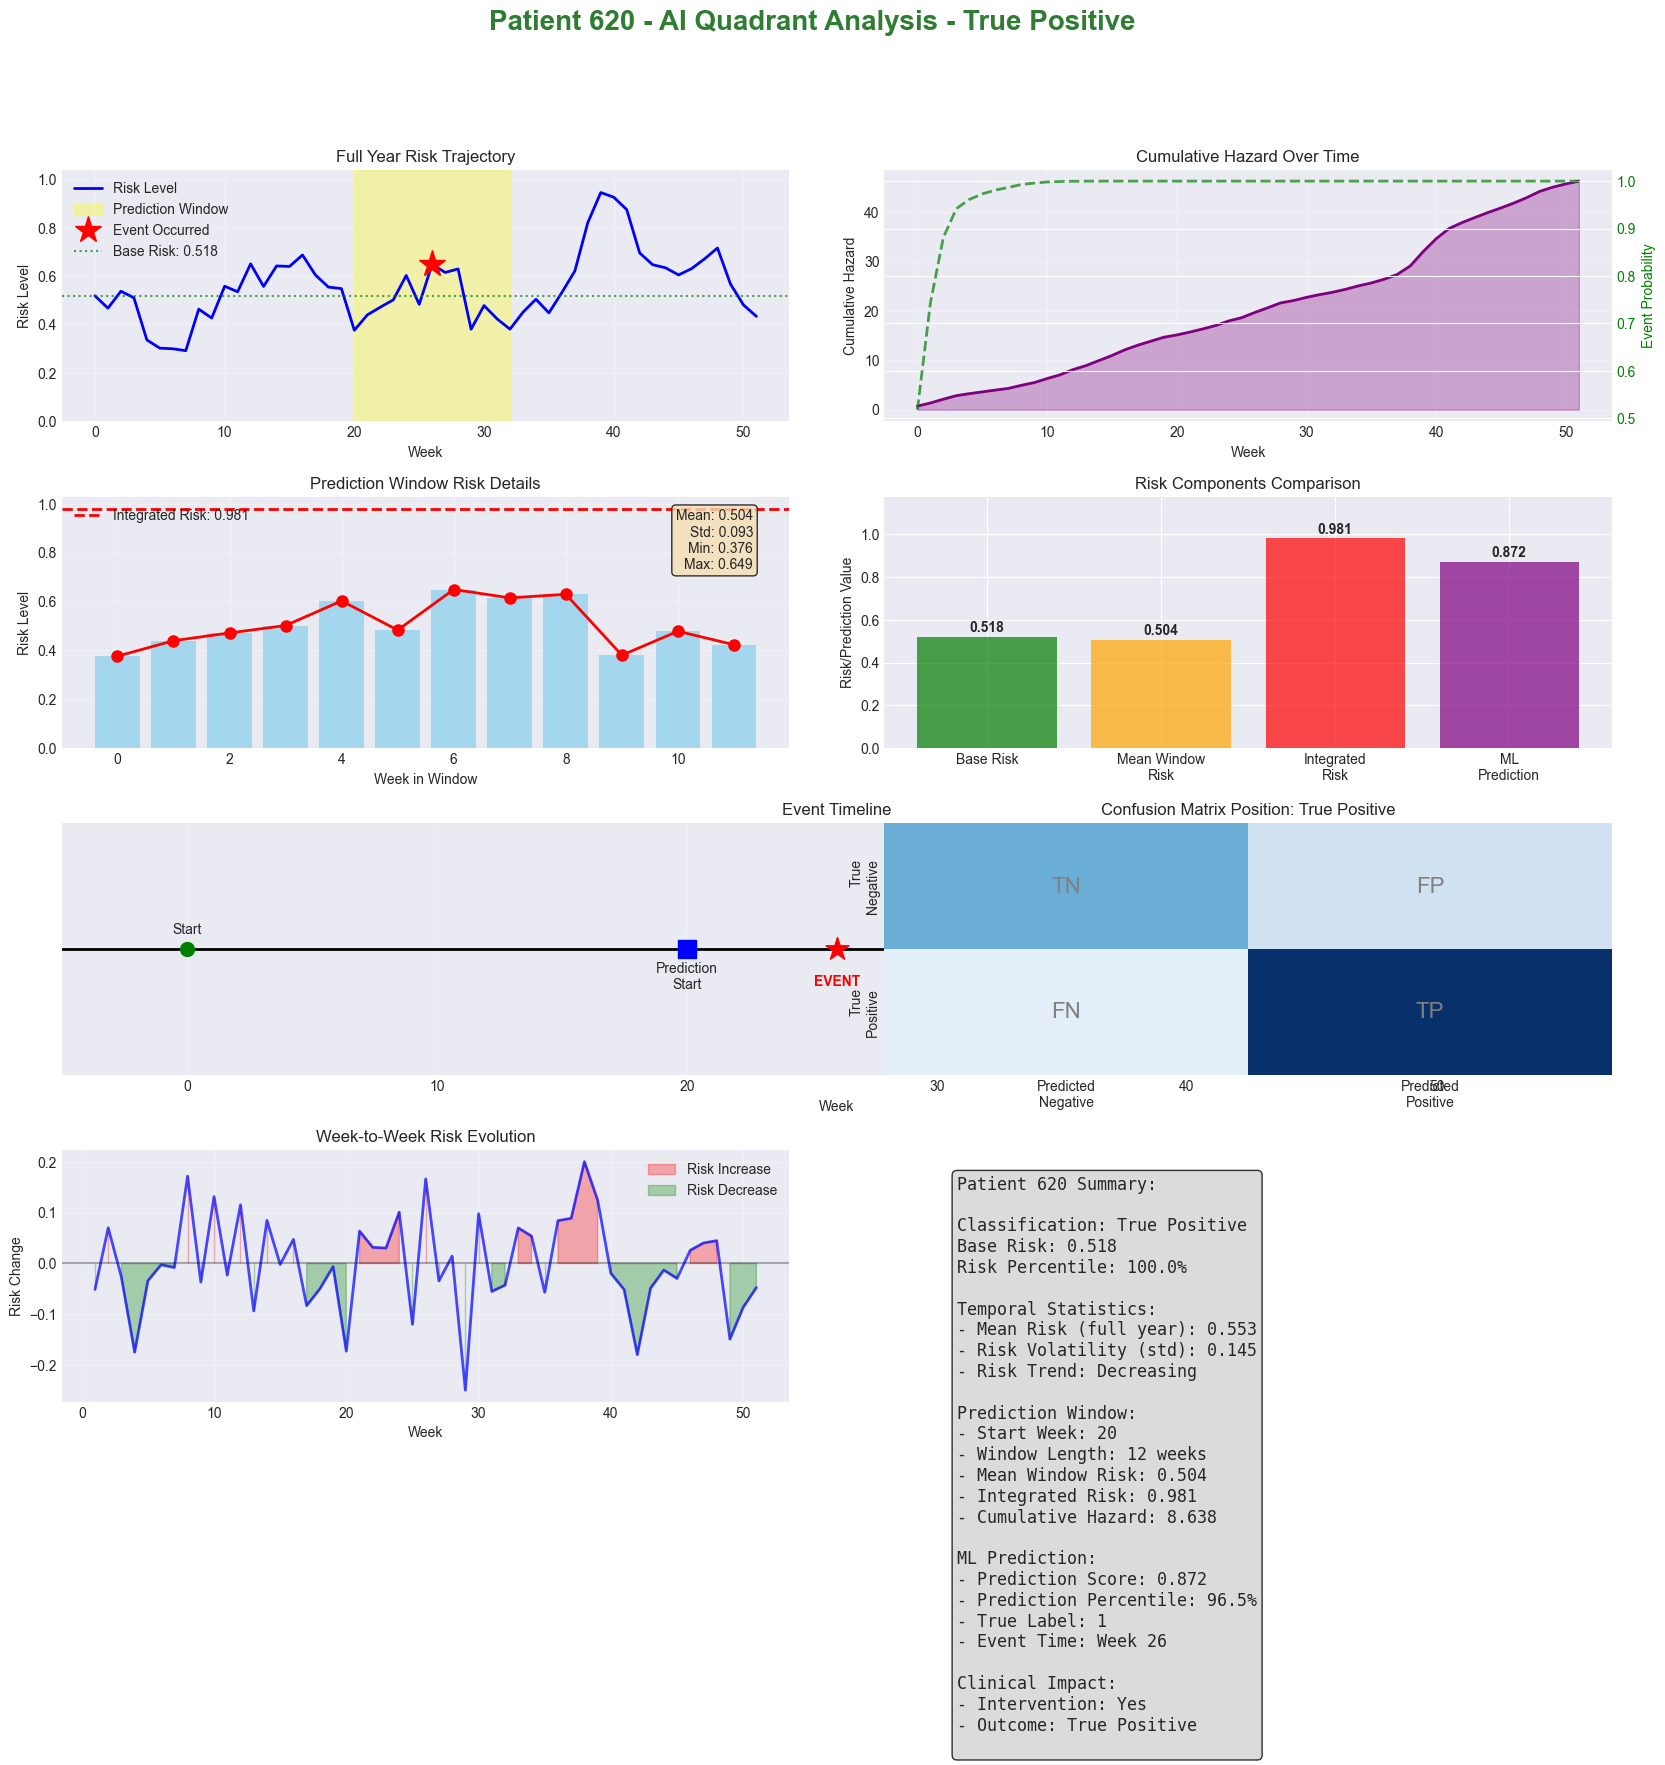


True Positive Patient 620 Summary:
Classification: True Positive
Base Risk: 0.518
Integrated Risk: 0.981
ML Prediction: 0.872
Event Time: Week 26
Risk Percentile: 100.0%


In [19]:
# Select a True Positive patient
if 'True Positive' in outcome_analysis['sample_patients'] and len(outcome_analysis['sample_patients']['True Positive']) > 0:
    tp_patient = outcome_analysis['sample_patients']['True Positive'][0]
    
    print(f"Analyzing True Positive Patient {tp_patient}...")
    
    tp_analysis = analyze_patient_journey_enhanced(
        patient_id=tp_patient,
        temporal_risk_matrix=temporal_matrix,
        prediction_start=prediction_start,
        window_length=window_length,
        predictions=predictions,
        true_labels=true_labels,
        event_times=event_times,
        integrated_risks=integrated_risks,
        base_risks=base_risks,
        intervention_mask=intervention_mask,
        figsize=(20, 16)
    )
    
    print(f"\nTrue Positive Patient {tp_patient} Summary:")
    print(f"Classification: {tp_analysis['classification']}")
    print(f"Base Risk: {tp_analysis['base_risk']:.3f}")
    print(f"Integrated Risk: {tp_analysis['integrated_risk']:.3f}")
    print(f"ML Prediction: {tp_analysis['ml_prediction']:.3f}")
    print(f"Event Time: Week {tp_analysis['event_time']}")
    print(f"Risk Percentile: {tp_analysis['risk_percentile']:.1f}%")
else:
    print("No True Positive patients found in sample.")

### False Positive Patient Analysis

Now let's examine a False Positive patient - one who was flagged as high risk by the AI but didn't actually have an event.

Analyzing False Positive Patient 152...


/Users/michaeldraugelis/Library/CloudStorage/Dropbox/proj/pop-ml-simulator/src/pop_ml_simulator/ml_simulation.py:1657: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


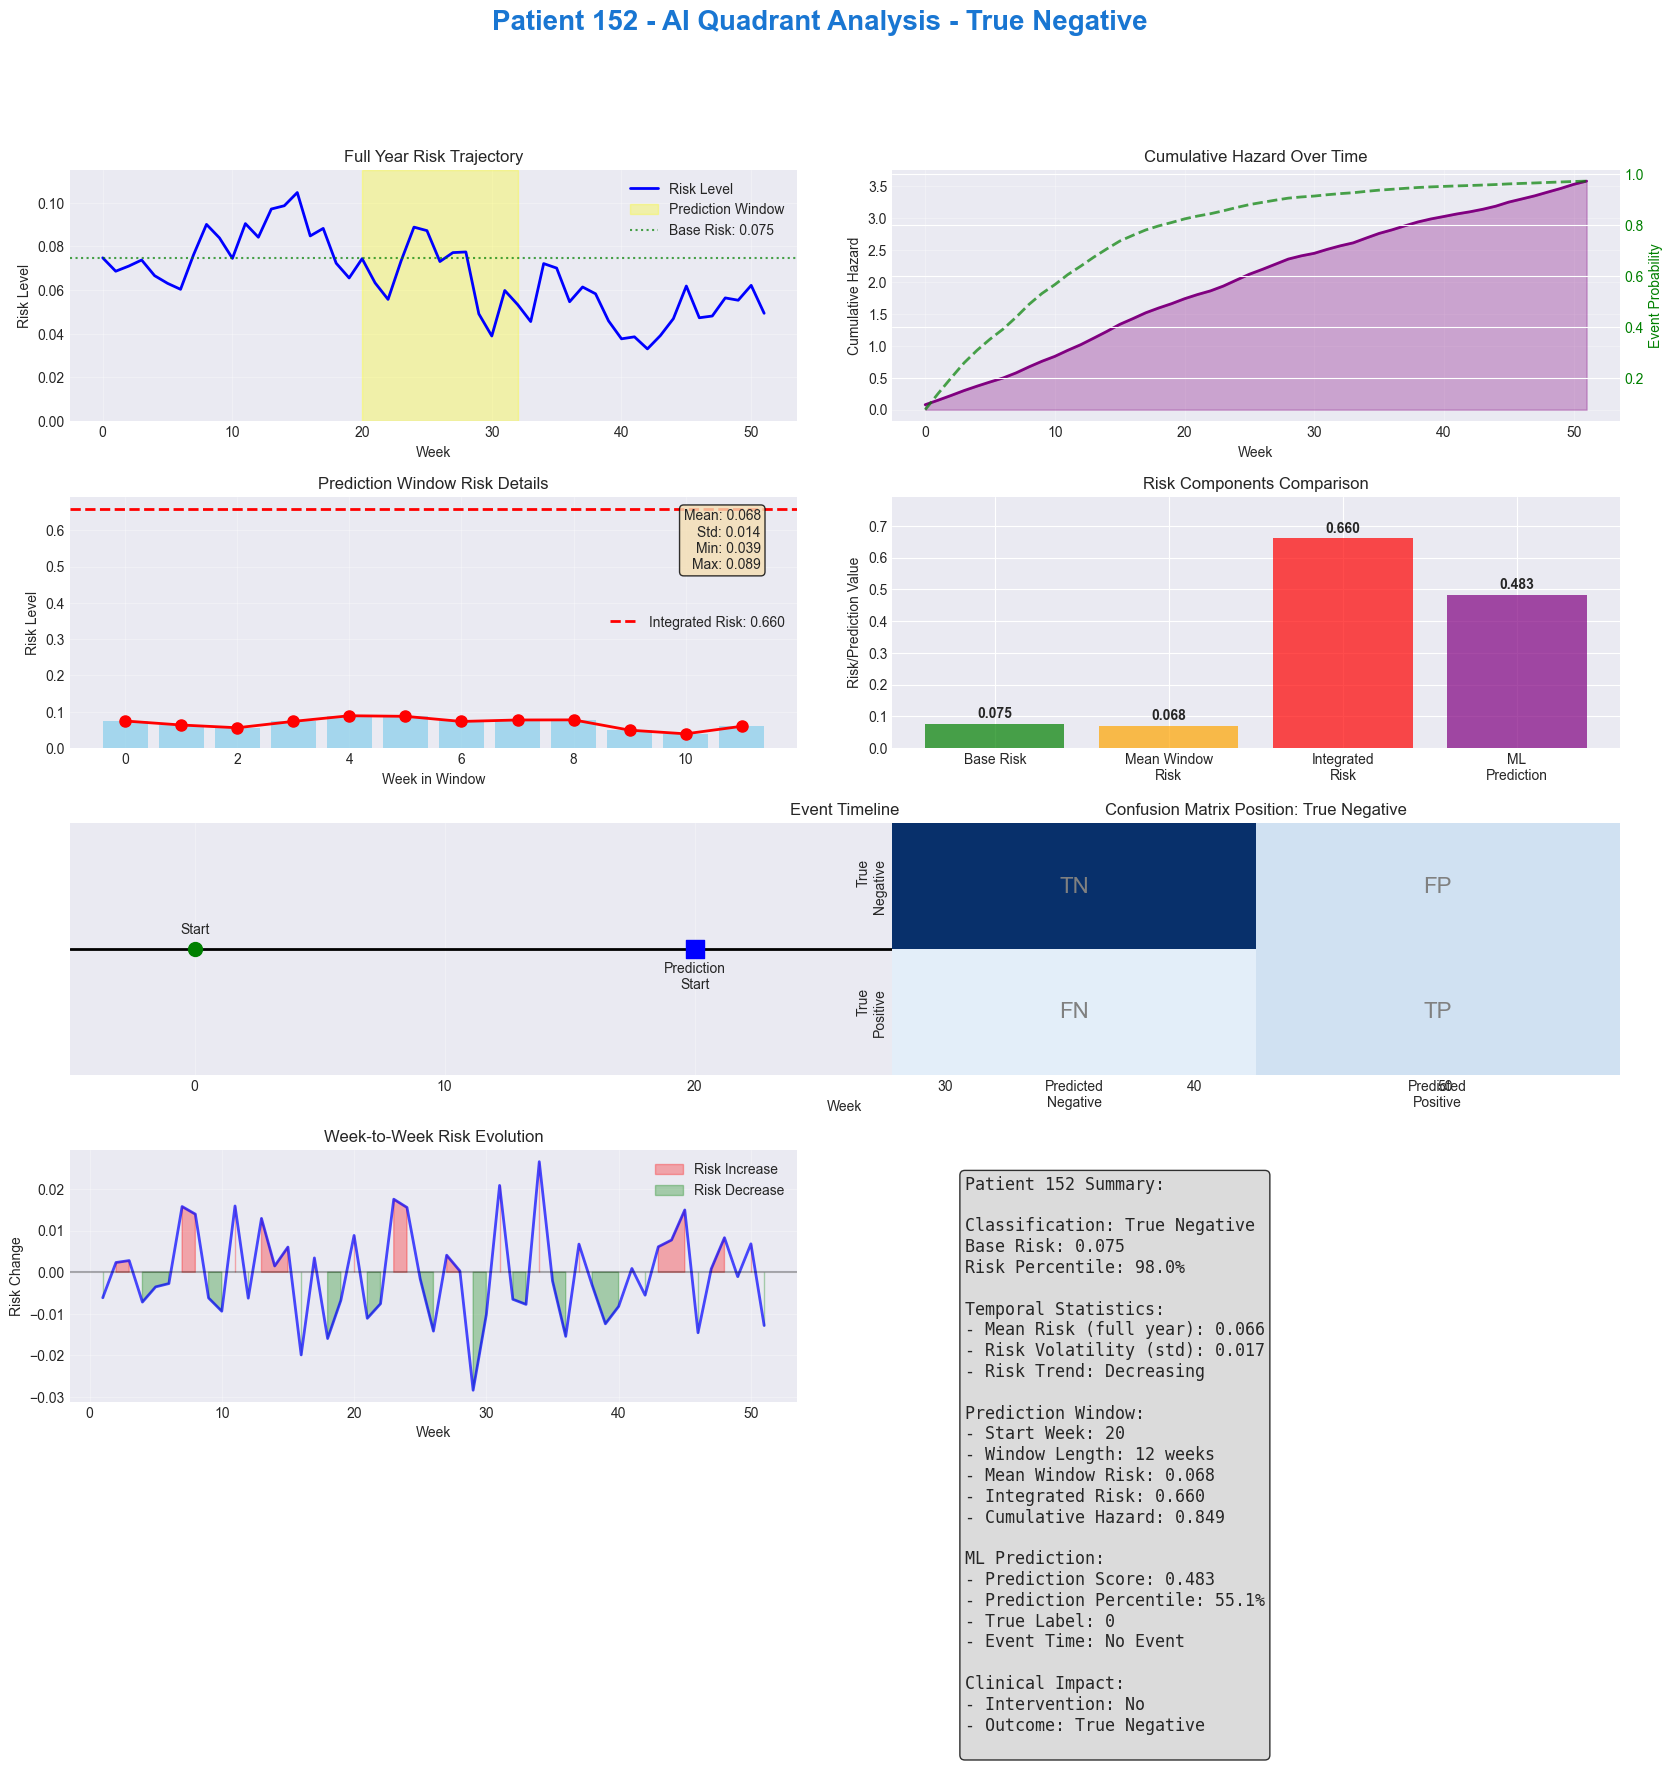


False Positive Patient 152 Summary:
Classification: True Negative
Base Risk: 0.075
Integrated Risk: 0.660
ML Prediction: 0.483
Event Time: No Event
Risk Percentile: 98.0%


In [20]:
# Select a False Positive patient
if 'False Positive' in outcome_analysis['sample_patients'] and len(outcome_analysis['sample_patients']['False Positive']) > 0:
    fp_patient = outcome_analysis['sample_patients']['False Positive'][0]
    
    print(f"Analyzing False Positive Patient {fp_patient}...")
    
    fp_analysis = analyze_patient_journey_enhanced(
        patient_id=fp_patient,
        temporal_risk_matrix=temporal_matrix,
        prediction_start=prediction_start,
        window_length=window_length,
        predictions=predictions,
        true_labels=true_labels,
        event_times=event_times,
        integrated_risks=integrated_risks,
        base_risks=base_risks,
        intervention_mask=intervention_mask,
        figsize=(20, 16)
    )
    
    print(f"\nFalse Positive Patient {fp_patient} Summary:")
    print(f"Classification: {fp_analysis['classification']}")
    print(f"Base Risk: {fp_analysis['base_risk']:.3f}")
    print(f"Integrated Risk: {fp_analysis['integrated_risk']:.3f}")
    print(f"ML Prediction: {fp_analysis['ml_prediction']:.3f}")
    print(f"Event Time: {'Week ' + str(fp_analysis['event_time']) if fp_analysis['event_time'] >= 0 else 'No Event'}")
    print(f"Risk Percentile: {fp_analysis['risk_percentile']:.1f}%")
else:
    print("No False Positive patients found in sample.")

### False Negative Patient Analysis

Let's examine a False Negative patient - one who was missed by the AI but actually had an event.

Analyzing False Negative Patient 1452...


/Users/michaeldraugelis/Library/CloudStorage/Dropbox/proj/pop-ml-simulator/src/pop_ml_simulator/ml_simulation.py:1657: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


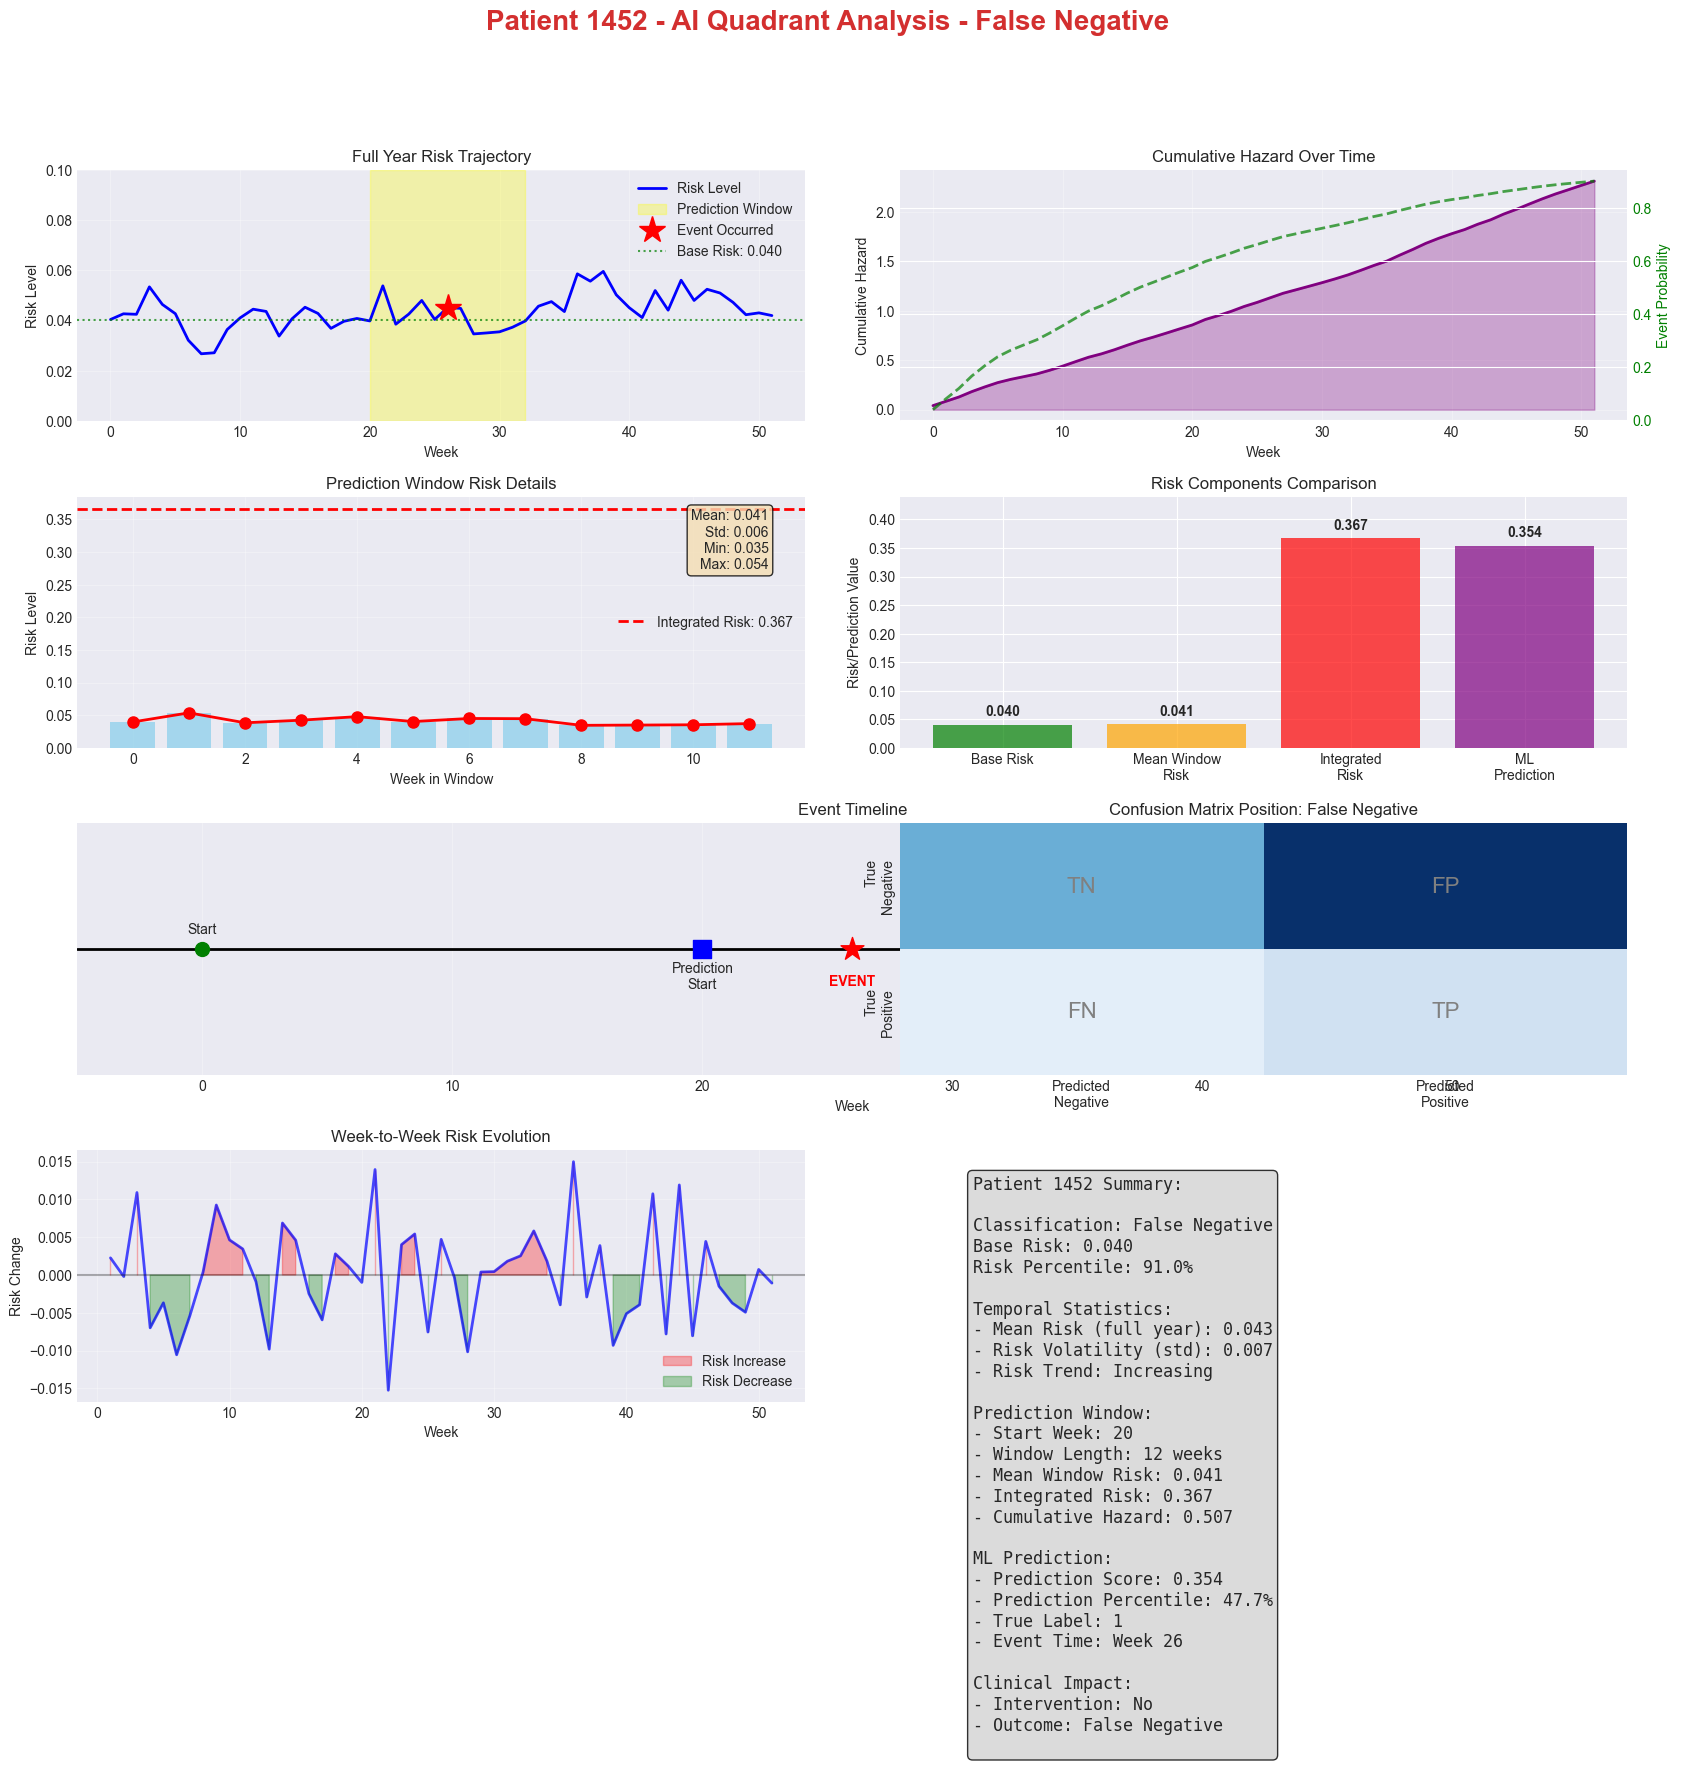


False Negative Patient 1452 Summary:
Classification: False Negative
Base Risk: 0.040
Integrated Risk: 0.367
ML Prediction: 0.354
Event Time: Week 26
Risk Percentile: 91.0%


In [21]:
# Select a False Negative patient
if 'False Negative' in outcome_analysis['sample_patients'] and len(outcome_analysis['sample_patients']['False Negative']) > 0:
    fn_patient = outcome_analysis['sample_patients']['False Negative'][0]
    
    print(f"Analyzing False Negative Patient {fn_patient}...")
    
    fn_analysis = analyze_patient_journey_enhanced(
        patient_id=fn_patient,
        temporal_risk_matrix=temporal_matrix,
        prediction_start=prediction_start,
        window_length=window_length,
        predictions=predictions,
        true_labels=true_labels,
        event_times=event_times,
        integrated_risks=integrated_risks,
        base_risks=base_risks,
        intervention_mask=intervention_mask,
        figsize=(20, 16)
    )
    
    print(f"\nFalse Negative Patient {fn_patient} Summary:")
    print(f"Classification: {fn_analysis['classification']}")
    print(f"Base Risk: {fn_analysis['base_risk']:.3f}")
    print(f"Integrated Risk: {fn_analysis['integrated_risk']:.3f}")
    print(f"ML Prediction: {fn_analysis['ml_prediction']:.3f}")
    print(f"Event Time: Week {fn_analysis['event_time']}")
    print(f"Risk Percentile: {fn_analysis['risk_percentile']:.1f}%")
else:
    print("No False Negative patients found in sample.")

## Clinical Impact Analysis

Now let's calculate the clinical impact metrics for each quadrant, including NNT (Number Needed to Treat) and resource utilization.

Calculating clinical impact metrics...

CLINICAL IMPACT ANALYSIS

Intervention Strategy Overview:
AI Sensitivity (for high risk): 67.2%
AI Specificity (for high risk): 100.0%
AI PPV (for high risk): 100.0%
AI NPV (for high risk): 51.2%
Flag rate: 50.0%
Resource efficiency: 0.017 events preventable per patient flagged

Quadrant-Specific Metrics:

HIGH PRIORITY:
  Patients: 1000 (50.0%)
  Event rate: 5.3%
  Mean risk: 0.797
  Mean prediction: 0.721
  NNT: 62.9
  Events preventable: 15.9

MISSED OPPORTUNITIES:
  Patients: 488 (24.4%)
  Event rate: 0.6%
  Mean risk: 0.248
  Mean prediction: 0.249
  NNT: 542.2
  Events preventable: 0.9

FALSE ALARMS:
  Patients: 0 (0.0%)
  Event rate: 0.0%
  Mean risk: 0.000
  Mean prediction: 0.000
  NNT: Not applicable (no events)
  Events preventable: 0

CORRECT REJECTIONS:
  Patients: 512 (25.6%)
  Event rate: 0.2%
  Mean risk: 0.029
  Mean prediction: 0.129
  NNT: 1706.7
  Events preventable: 0.3

Overall Impact:
Total events preventable: 17.1
Wasted r

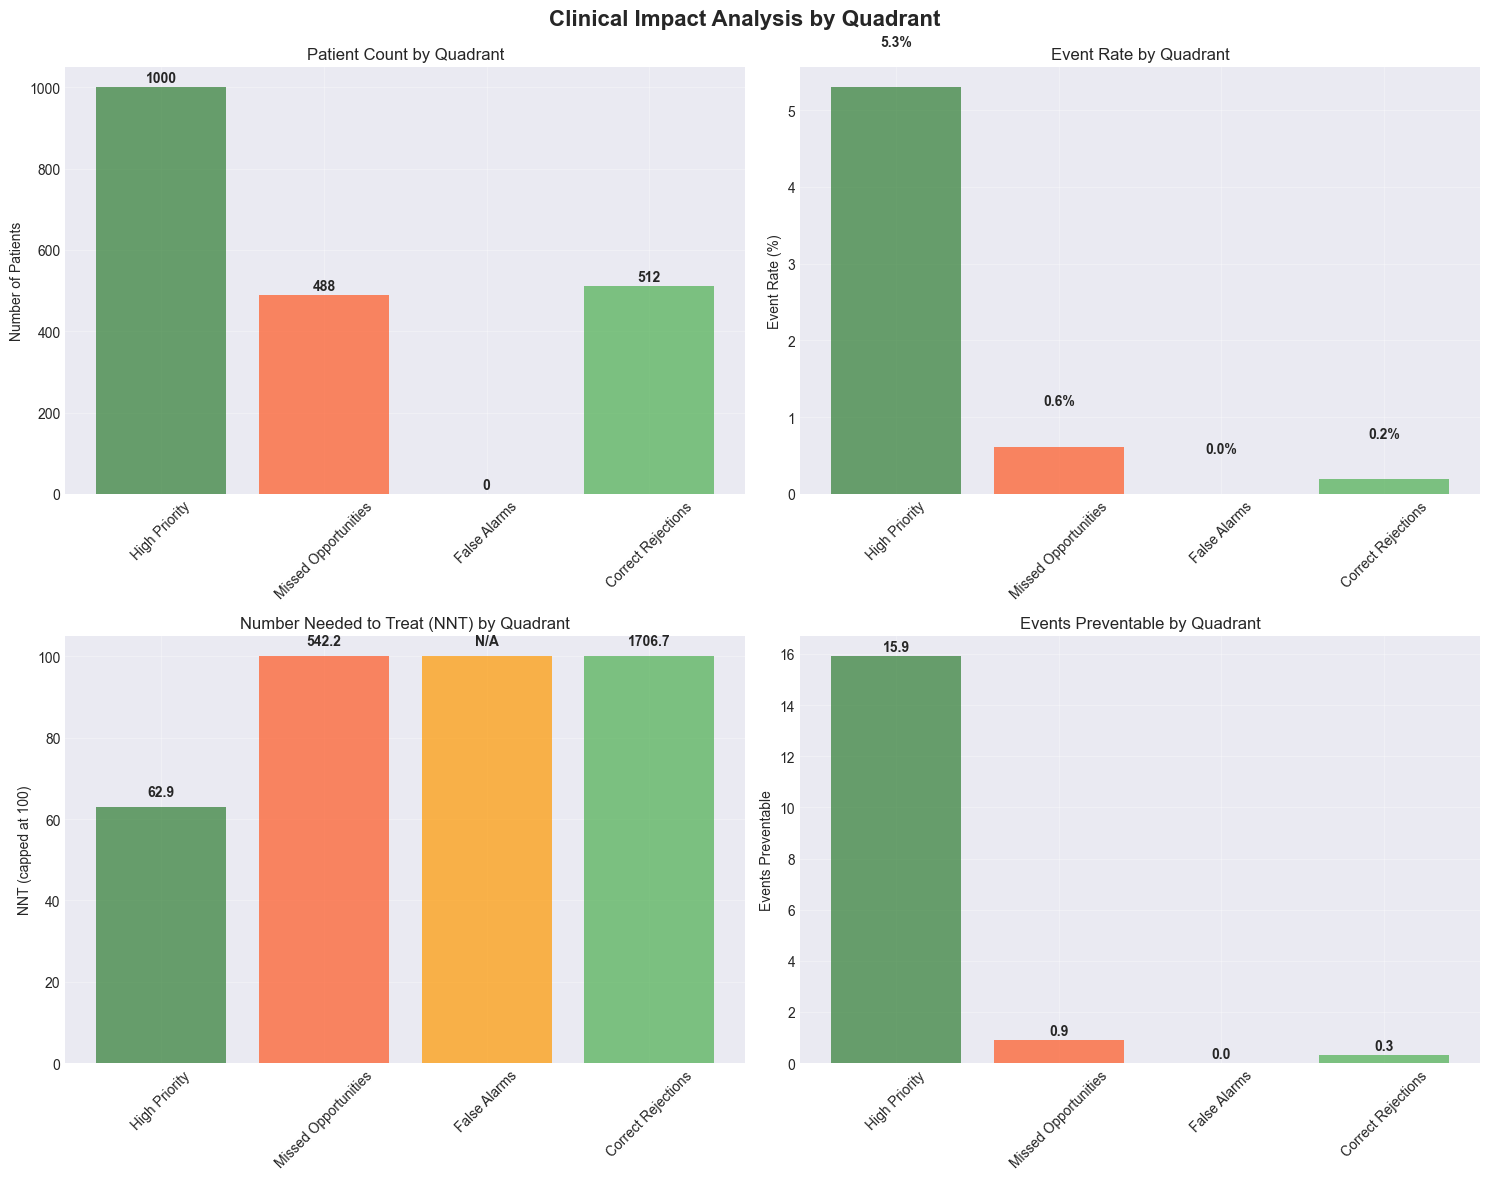

In [22]:
# Define calculate_quadrant_metrics function locally since it's not in the module
def calculate_quadrant_metrics(
    true_risks,
    predictions,
    true_events,
    risk_threshold=0.1,
    prediction_threshold=None,
    intervention_effectiveness=0.3
):
    """Calculate clinical impact metrics for each quadrant."""
    
    # Use median prediction as threshold if not specified
    if prediction_threshold is None:
        prediction_threshold = np.median(predictions)
    
    # Identify quadrants
    high_risk = true_risks >= risk_threshold
    ai_flagged = predictions >= prediction_threshold
    
    # Define quadrants
    high_priority = high_risk & ai_flagged
    missed_opportunities = high_risk & ~ai_flagged
    false_alarms = ~high_risk & ai_flagged
    correct_rejections = ~high_risk & ~ai_flagged
    
    # Calculate metrics for each quadrant
    quadrant_metrics = {}
    
    quadrants = {
        'high_priority': high_priority,
        'missed_opportunities': missed_opportunities,
        'false_alarms': false_alarms,
        'correct_rejections': correct_rejections
    }
    
    total_patients = len(true_risks)
    
    for name, mask in quadrants.items():
        count = np.sum(mask)
        event_rate = np.mean(true_events[mask]) if count > 0 else 0
        
        # Calculate NNT based on intervention effectiveness
        if event_rate > 0 and intervention_effectiveness > 0:
            nnt = 1 / (event_rate * intervention_effectiveness)
            events_preventable = count * event_rate * intervention_effectiveness
        else:
            nnt = np.inf
            events_preventable = 0
        
        quadrant_metrics[name] = {
            'count': count,
            'percentage': count / total_patients * 100,
            'event_rate': event_rate,
            'mean_risk': np.mean(true_risks[mask]) if count > 0 else 0,
            'mean_prediction': np.mean(predictions[mask]) if count > 0 else 0,
            'nnt': nnt,
            'events_preventable': events_preventable
        }
    
    # Calculate strategy metrics
    tp = np.sum(high_risk & ai_flagged)
    fn = np.sum(high_risk & ~ai_flagged)
    fp = np.sum(~high_risk & ai_flagged)
    tn = np.sum(~high_risk & ~ai_flagged)
    
    ai_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    ai_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ai_ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    ai_npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    total_events_preventable = sum(m['events_preventable'] for m in quadrant_metrics.values())
    
    strategy_metrics = {
        'ai_sensitivity': ai_sensitivity,
        'ai_specificity': ai_specificity,
        'ai_ppv': ai_ppv,
        'ai_npv': ai_npv,
        'flag_rate': np.mean(ai_flagged),
        'resource_efficiency': total_events_preventable / np.sum(ai_flagged) if np.sum(ai_flagged) > 0 else 0,
        'wasted_resources': np.sum(false_alarms),
        'missed_opportunities': np.sum(missed_opportunities),
        'total_events_preventable': total_events_preventable
    }
    
    return {
        'quadrant_metrics': quadrant_metrics,
        'strategy_metrics': strategy_metrics,
        'thresholds': {
            'risk_threshold': risk_threshold,
            'prediction_threshold': prediction_threshold
        }
    }

# Calculate detailed quadrant metrics
print("Calculating clinical impact metrics...")

quadrant_metrics = calculate_quadrant_metrics(
    true_risks=integrated_risks,
    predictions=predictions,
    true_events=true_labels,
    risk_threshold=0.1,
    prediction_threshold=stats['thresholds']['prediction_threshold'],
    intervention_effectiveness=0.3  # 30% relative risk reduction
)

print("\n" + "="*80)
print("CLINICAL IMPACT ANALYSIS")
print("="*80)

print(f"\nIntervention Strategy Overview:")
strategy = quadrant_metrics['strategy_metrics']
print(f"AI Sensitivity (for high risk): {strategy['ai_sensitivity']:.1%}")
print(f"AI Specificity (for high risk): {strategy['ai_specificity']:.1%}")
print(f"AI PPV (for high risk): {strategy['ai_ppv']:.1%}")
print(f"AI NPV (for high risk): {strategy['ai_npv']:.1%}")
print(f"Flag rate: {strategy['flag_rate']:.1%}")
print(f"Resource efficiency: {strategy['resource_efficiency']:.3f} events preventable per patient flagged")

print(f"\nQuadrant-Specific Metrics:")
for quadrant, metrics in quadrant_metrics['quadrant_metrics'].items():
    print(f"\n{quadrant.upper().replace('_', ' ')}:")
    print(f"  Patients: {metrics['count']} ({metrics['percentage']:.1f}%)")
    print(f"  Event rate: {metrics['event_rate']:.1%}")
    print(f"  Mean risk: {metrics['mean_risk']:.3f}")
    print(f"  Mean prediction: {metrics['mean_prediction']:.3f}")
    if metrics['nnt'] != np.inf:
        print(f"  NNT: {metrics['nnt']:.1f}")
        print(f"  Events preventable: {metrics['events_preventable']:.1f}")
    else:
        print(f"  NNT: Not applicable (no events)")
        print(f"  Events preventable: 0")

print(f"\nOverall Impact:")
total_preventable = sum(q['events_preventable'] for q in quadrant_metrics['quadrant_metrics'].values())
print(f"Total events preventable: {total_preventable:.1f}")
print(f"Wasted resources (False Alarms): {strategy['wasted_resources']} patients")
print(f"Missed opportunities: {strategy['missed_opportunities']} patients")

# Create a summary visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Clinical Impact Analysis by Quadrant', fontsize=16, fontweight='bold')

quadrant_names = ['High Priority', 'Missed Opportunities', 'False Alarms', 'Correct Rejections']
quadrant_keys = ['high_priority', 'missed_opportunities', 'false_alarms', 'correct_rejections']
colors = ['#2E7D32', '#FF5722', '#FF9800', '#4CAF50']

# Patient counts
ax = axes[0, 0]
counts = [quadrant_metrics['quadrant_metrics'][k]['count'] for k in quadrant_keys]
bars = ax.bar(quadrant_names, counts, color=colors, alpha=0.7)
ax.set_title('Patient Count by Quadrant')
ax.set_ylabel('Number of Patients')
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
           f'{count}', ha='center', va='bottom', fontweight='bold')

# Event rates
ax = axes[0, 1]
event_rates = [quadrant_metrics['quadrant_metrics'][k]['event_rate'] * 100 for k in quadrant_keys]
bars = ax.bar(quadrant_names, event_rates, color=colors, alpha=0.7)
ax.set_title('Event Rate by Quadrant')
ax.set_ylabel('Event Rate (%)')
for bar, rate in zip(bars, event_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
           f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

# NNT values
ax = axes[1, 0]
nnts = [quadrant_metrics['quadrant_metrics'][k]['nnt'] for k in quadrant_keys]
# Cap NNT at 100 for visualization
nnts_capped = [min(nnt, 100) if nnt != np.inf else 100 for nnt in nnts]
bars = ax.bar(quadrant_names, nnts_capped, color=colors, alpha=0.7)
ax.set_title('Number Needed to Treat (NNT) by Quadrant')
ax.set_ylabel('NNT (capped at 100)')
for bar, nnt, nnt_cap in zip(bars, nnts, nnts_capped):
    if nnt != np.inf:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
               f'{nnt:.1f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
               'N/A', ha='center', va='bottom', fontweight='bold')

# Events preventable
ax = axes[1, 1]
preventable = [quadrant_metrics['quadrant_metrics'][k]['events_preventable'] for k in quadrant_keys]
bars = ax.bar(quadrant_names, preventable, color=colors, alpha=0.7)
ax.set_title('Events Preventable by Quadrant')
ax.set_ylabel('Events Preventable')
for bar, prev in zip(bars, preventable):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
           f'{prev:.1f}', ha='center', va='bottom', fontweight='bold')

# Rotate x-axis labels for better readability
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Temporal Pattern Analysis

Let's analyze how risk patterns evolve over time for each quadrant to understand why the AI makes certain predictions.

Analyzing temporal patterns by quadrant...


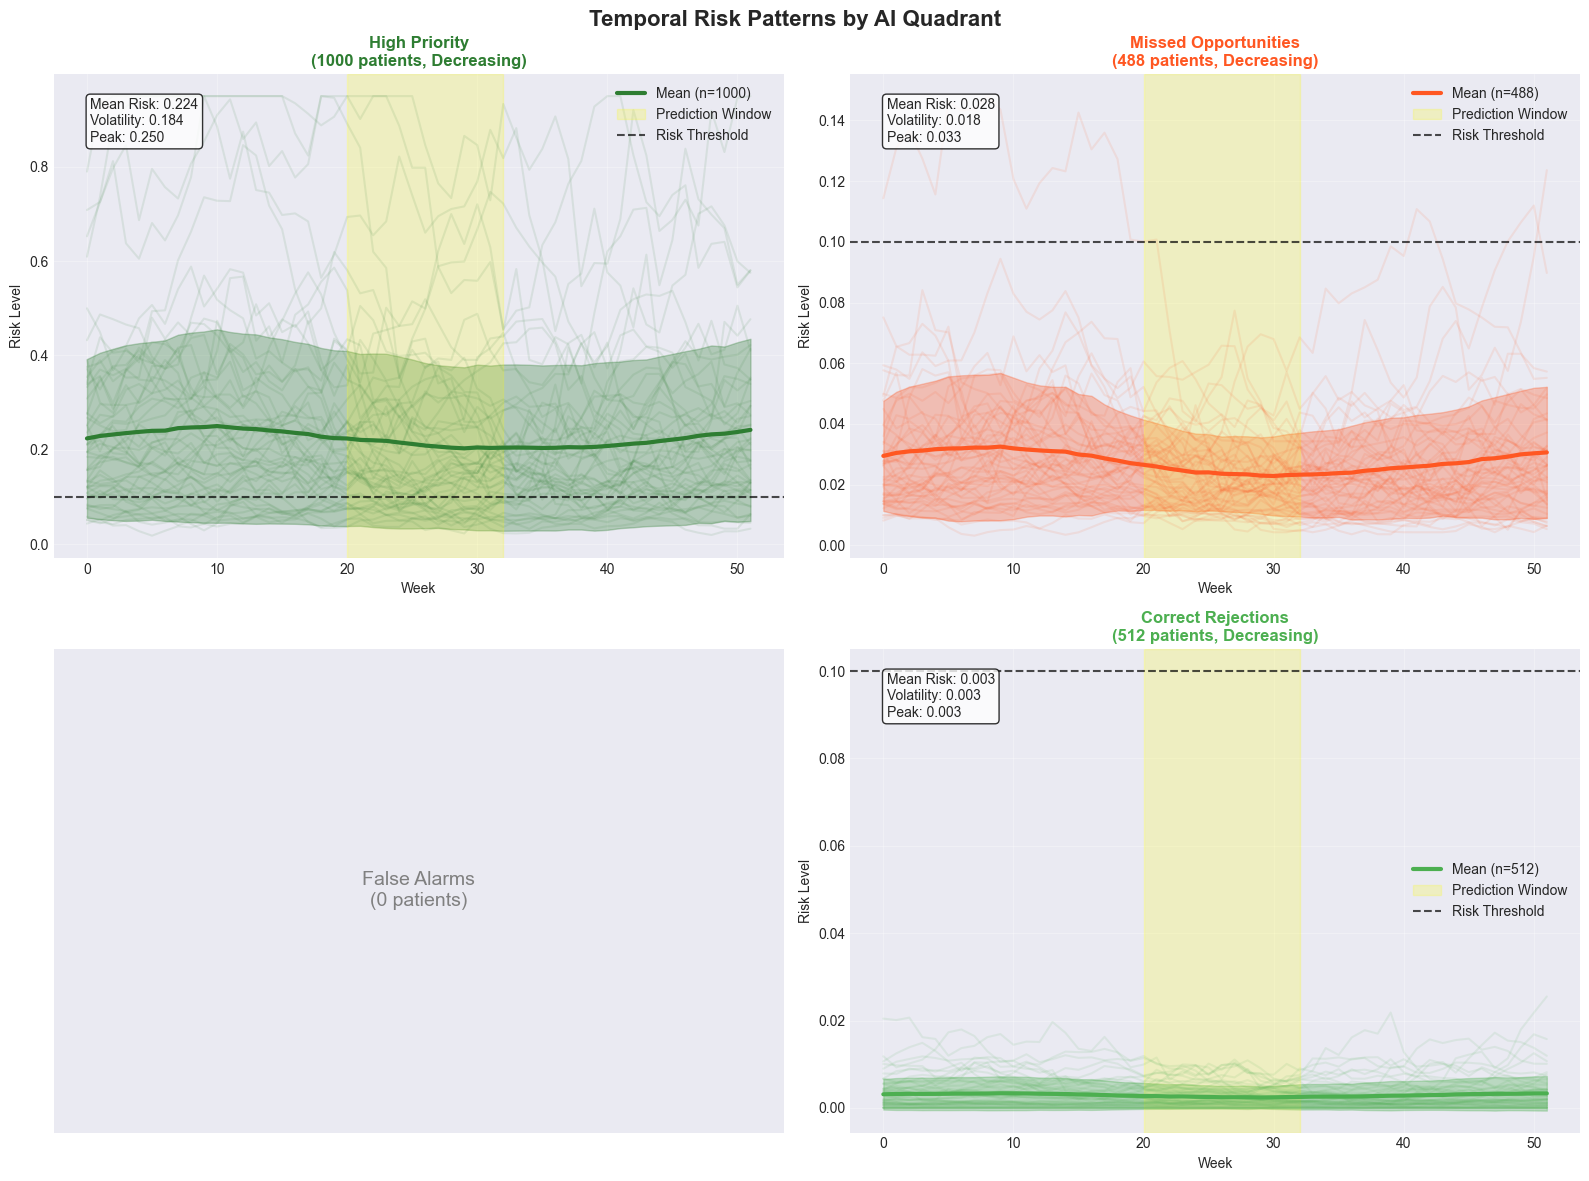


Temporal Pattern Insights:

High Priority:
  Patients: 1000
  Overall trend: Decreasing (slope: -0.0005)
  Mean volatility: 0.059
  Initial risk: 0.224
  Final risk: 0.242
  Peak risk: 0.250 (week 10)

Missed Opportunities:
  Patients: 488
  Overall trend: Decreasing (slope: -0.0001)
  Mean volatility: 0.008
  Initial risk: 0.029
  Final risk: 0.031
  Peak risk: 0.033 (week 9)

Correct Rejections:
  Patients: 512
  Overall trend: Decreasing (slope: -0.0000)
  Mean volatility: 0.001
  Initial risk: 0.003
  Final risk: 0.003
  Peak risk: 0.003 (week 9)


In [23]:
# Analyze temporal patterns by quadrant
print("Analyzing temporal patterns by quadrant...")

# Note: This function is not implemented in the current code but would be a valuable addition
# For now, let's create a simpler temporal analysis

# Create quadrant masks based on our thresholds
risk_threshold = 0.1
prediction_threshold = stats['thresholds']['prediction_threshold']

high_risk = integrated_risks >= risk_threshold
ai_flagged = predictions >= prediction_threshold

quadrant_masks = {
    'High Priority': high_risk & ai_flagged,
    'Missed Opportunities': high_risk & ~ai_flagged,
    'False Alarms': ~high_risk & ai_flagged,
    'Correct Rejections': ~high_risk & ~ai_flagged
}

quadrant_colors = {
    'High Priority': '#2E7D32',
    'Missed Opportunities': '#FF5722',
    'False Alarms': '#FF9800',
    'Correct Rejections': '#4CAF50'
}

# Create temporal pattern visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

fig.suptitle('Temporal Risk Patterns by AI Quadrant', fontsize=16, fontweight='bold')

for i, (quad_name, mask) in enumerate(quadrant_masks.items()):
    ax = axes[i]
    
    if np.sum(mask) > 0:
        # Get temporal trajectories for this quadrant
        quadrant_trajectories = temporal_matrix[mask]
        
        # Calculate mean trajectory and confidence bands
        mean_trajectory = np.mean(quadrant_trajectories, axis=0)
        std_trajectory = np.std(quadrant_trajectories, axis=0)
        
        # Sample trajectories for visualization (max 50)
        n_trajectories = quadrant_trajectories.shape[0]
        if n_trajectories > 50:
            sample_indices = np.random.choice(n_trajectories, 50, replace=False)
            sample_trajectories = quadrant_trajectories[sample_indices]
        else:
            sample_trajectories = quadrant_trajectories
        
        # Plot individual trajectories
        time_points = np.arange(n_timesteps)
        for traj in sample_trajectories:
            ax.plot(time_points, traj, alpha=0.1, color=quadrant_colors[quad_name])
        
        # Plot mean trajectory
        ax.plot(time_points, mean_trajectory, color=quadrant_colors[quad_name], 
               linewidth=3, label=f'Mean (n={n_trajectories})')
        
        # Plot confidence bands
        ax.fill_between(time_points, 
                       mean_trajectory - std_trajectory,
                       mean_trajectory + std_trajectory,
                       alpha=0.3, color=quadrant_colors[quad_name])
        
        # Add prediction window
        ax.axvspan(prediction_start, prediction_start + window_length,
                   alpha=0.2, color='yellow', label='Prediction Window')
        
        # Add risk threshold line
        ax.axhline(y=risk_threshold, color='black', linestyle='--', 
                  alpha=0.7, label='Risk Threshold')
        
        # Calculate trend
        trend_slope = np.polyfit(time_points, mean_trajectory, 1)[0]
        trend = 'Increasing' if trend_slope > 0 else 'Decreasing'
        
        # Customize subplot
        ax.set_title(f'{quad_name}\n({n_trajectories} patients, {trend})', 
                    fontweight='bold', color=quadrant_colors[quad_name])
        ax.set_xlabel('Week')
        ax.set_ylabel('Risk Level')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Add statistics
        stats_text = f'Mean Risk: {np.mean(mean_trajectory):.3f}\n'
        stats_text += f'Volatility: {np.mean(std_trajectory):.3f}\n'
        stats_text += f'Peak: {np.max(mean_trajectory):.3f}'
        
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
               fontsize=10, va='top', ha='left',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        # Empty quadrant
        ax.text(0.5, 0.5, f'{quad_name}\n(0 patients)', 
               transform=ax.transAxes, ha='center', va='center',
               fontsize=14, color='gray')
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

# Print temporal pattern insights
print("\nTemporal Pattern Insights:")
for quad_name, mask in quadrant_masks.items():
    if np.sum(mask) > 0:
        trajectories = temporal_matrix[mask]
        mean_traj = np.mean(trajectories, axis=0)
        
        # Calculate trend
        trend_slope = np.polyfit(np.arange(len(mean_traj)), mean_traj, 1)[0]
        trend = 'Increasing' if trend_slope > 0 else 'Decreasing'
        
        # Calculate volatility
        volatility = np.mean(np.std(trajectories, axis=1))
        
        print(f"\n{quad_name}:")
        print(f"  Patients: {np.sum(mask)}")
        print(f"  Overall trend: {trend} (slope: {trend_slope:.4f})")
        print(f"  Mean volatility: {volatility:.3f}")
        print(f"  Initial risk: {mean_traj[0]:.3f}")
        print(f"  Final risk: {mean_traj[-1]:.3f}")
        print(f"  Peak risk: {np.max(mean_traj):.3f} (week {np.argmax(mean_traj)})")

## Threshold Sensitivity Analysis

Let's explore how changing the risk and prediction thresholds affects the quadrant distributions.

Performing threshold sensitivity analysis...


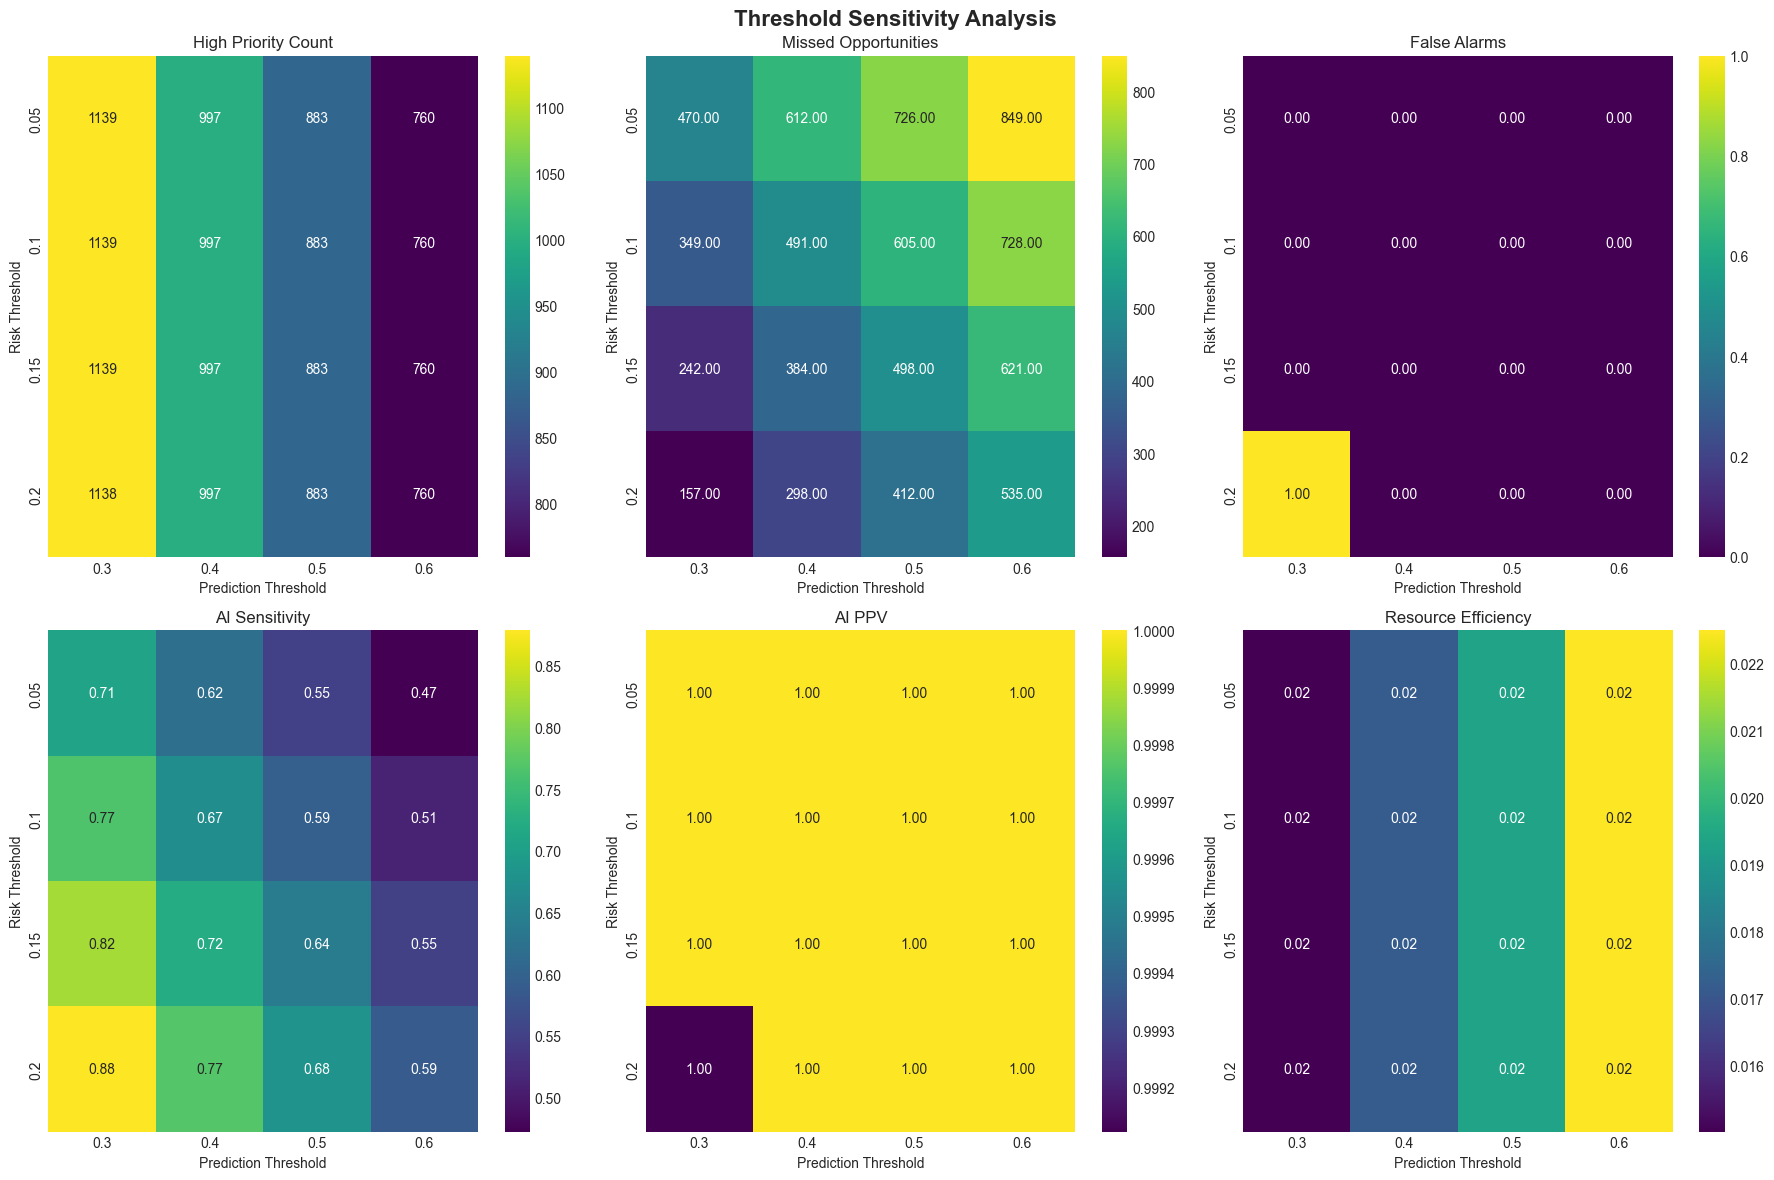


Optimal Threshold Combinations:

Highest Resource Efficiency:
  Risk threshold: 0.05
  Prediction threshold: 0.60
  Resource efficiency: 0.022
  High priority patients: 760.0
  Events preventable: 17.1

Highest AI Sensitivity:
  Risk threshold: 0.20
  Prediction threshold: 0.30
  AI sensitivity: 0.879
  Missed opportunities: 157.0

Highest AI PPV:
  Risk threshold: 0.05
  Prediction threshold: 0.30
  AI PPV: 1.000
  False alarms: 0.0


In [24]:
# Threshold sensitivity analysis
print("Performing threshold sensitivity analysis...")

# Test different threshold combinations
risk_thresholds = [0.05, 0.1, 0.15, 0.2]
prediction_thresholds = [0.3, 0.4, 0.5, 0.6]

# Create a grid of results
threshold_results = []

for risk_thresh in risk_thresholds:
    for pred_thresh in prediction_thresholds:
        # Calculate quadrant metrics for this combination
        metrics = calculate_quadrant_metrics(
            true_risks=integrated_risks,
            predictions=predictions,
            true_events=true_labels,
            risk_threshold=risk_thresh,
            prediction_threshold=pred_thresh
        )
        
        # Extract key metrics
        result = {
            'risk_threshold': risk_thresh,
            'prediction_threshold': pred_thresh,
            'high_priority_count': metrics['quadrant_metrics']['high_priority']['count'],
            'missed_opportunities': metrics['quadrant_metrics']['missed_opportunities']['count'],
            'false_alarms': metrics['quadrant_metrics']['false_alarms']['count'],
            'correct_rejections': metrics['quadrant_metrics']['correct_rejections']['count'],
            'ai_sensitivity': metrics['strategy_metrics']['ai_sensitivity'],
            'ai_specificity': metrics['strategy_metrics']['ai_specificity'],
            'ai_ppv': metrics['strategy_metrics']['ai_ppv'],
            'total_events_preventable': metrics['strategy_metrics']['total_events_preventable'],
            'resource_efficiency': metrics['strategy_metrics']['resource_efficiency']
        }
        
        threshold_results.append(result)

# Convert to DataFrame for easier analysis
threshold_df = pd.DataFrame(threshold_results)

# Create heatmaps for key metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Threshold Sensitivity Analysis', fontsize=16, fontweight='bold')

metrics_to_plot = [
    ('high_priority_count', 'High Priority Count'),
    ('missed_opportunities', 'Missed Opportunities'),
    ('false_alarms', 'False Alarms'),
    ('ai_sensitivity', 'AI Sensitivity'),
    ('ai_ppv', 'AI PPV'),
    ('resource_efficiency', 'Resource Efficiency')
]

for i, (metric, title) in enumerate(metrics_to_plot):
    ax = axes[i // 3, i % 3]
    
    # Create pivot table for heatmap
    pivot_data = threshold_df.pivot(index='risk_threshold', 
                                   columns='prediction_threshold', 
                                   values=metric)
    
    # Create heatmap
    sns.heatmap(pivot_data, annot=True, fmt='.0f' if 'count' in metric else '.2f', 
                cmap='viridis', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Prediction Threshold')
    ax.set_ylabel('Risk Threshold')

plt.tight_layout()
plt.show()

# Find optimal threshold combinations
print("\nOptimal Threshold Combinations:")
print("\nHighest Resource Efficiency:")
best_efficiency = threshold_df.loc[threshold_df['resource_efficiency'].idxmax()]
print(f"  Risk threshold: {best_efficiency['risk_threshold']:.2f}")
print(f"  Prediction threshold: {best_efficiency['prediction_threshold']:.2f}")
print(f"  Resource efficiency: {best_efficiency['resource_efficiency']:.3f}")
print(f"  High priority patients: {best_efficiency['high_priority_count']}")
print(f"  Events preventable: {best_efficiency['total_events_preventable']:.1f}")

print("\nHighest AI Sensitivity:")
best_sensitivity = threshold_df.loc[threshold_df['ai_sensitivity'].idxmax()]
print(f"  Risk threshold: {best_sensitivity['risk_threshold']:.2f}")
print(f"  Prediction threshold: {best_sensitivity['prediction_threshold']:.2f}")
print(f"  AI sensitivity: {best_sensitivity['ai_sensitivity']:.3f}")
print(f"  Missed opportunities: {best_sensitivity['missed_opportunities']}")

print("\nHighest AI PPV:")
best_ppv = threshold_df.loc[threshold_df['ai_ppv'].idxmax()]
print(f"  Risk threshold: {best_ppv['risk_threshold']:.2f}")
print(f"  Prediction threshold: {best_ppv['prediction_threshold']:.2f}")
print(f"  AI PPV: {best_ppv['ai_ppv']:.3f}")
print(f"  False alarms: {best_ppv['false_alarms']}")

## Summary and Key Insights

Let's summarize the key insights from our AI Quadrant analysis.

In [25]:
# Summary analysis
print("" + "="*80)
print("AI QUADRANT ANALYSIS - SUMMARY INSIGHTS")
print("="*80)

# Overall performance summary
print(f"\n🎯 OVERALL PERFORMANCE:")
print(f"   Population: {n_patients:,} patients")
print(f"   ML Sensitivity: {ml_metrics['sensitivity']:.1%}")
print(f"   ML PPV: {ml_metrics['ppv']:.1%}")
print(f"   ML Specificity: {ml_metrics['specificity']:.1%}")
print(f"   Events in window: {np.sum(true_labels)} ({np.mean(true_labels):.1%})")

# Quadrant distribution
print(f"\n📊 QUADRANT DISTRIBUTION:")
for quadrant, data in stats.items():
    if isinstance(data, dict) and 'count' in data:
        percentage = data['count'] / stats['overall']['total_patients'] * 100
        print(f"   {quadrant}: {data['count']} patients ({percentage:.1f}%)")

# Clinical impact
print(f"\n🏥 CLINICAL IMPACT:")
strategy = quadrant_metrics['strategy_metrics']
print(f"   Total events preventable: {strategy['total_events_preventable']:.1f}")
print(f"   Resource efficiency: {strategy['resource_efficiency']:.3f} events/patient flagged")
print(f"   Wasted resources: {strategy['wasted_resources']} false alarms")
print(f"   Missed opportunities: {strategy['missed_opportunities']} patients")

# NNT insights
print(f"\n💊 NUMBER NEEDED TO TREAT (NNT):")
for quadrant, metrics in quadrant_metrics['quadrant_metrics'].items():
    if metrics['count'] > 0:
        quadrant_name = quadrant.replace('_', ' ').title()
        if metrics['nnt'] != np.inf:
            print(f"   {quadrant_name}: {metrics['nnt']:.1f} (based on {metrics['event_rate']:.1%} event rate)")
        else:
            print(f"   {quadrant_name}: Not applicable (no events)")

# Key insights
print(f"\n💡 KEY INSIGHTS:")

# Insight 1: AI performance for high-risk identification
ai_sens = strategy['ai_sensitivity']
ai_ppv = strategy['ai_ppv']
if ai_sens > 0.7:
    print(f"   ✅ AI shows good sensitivity ({ai_sens:.1%}) for identifying high-risk patients")
else:
    print(f"   ⚠️ AI sensitivity ({ai_sens:.1%}) for high-risk patients could be improved")

if ai_ppv > 0.5:
    print(f"   ✅ AI shows good precision ({ai_ppv:.1%}) - most flagged patients are truly high-risk")
else:
    print(f"   ⚠️ AI precision ({ai_ppv:.1%}) indicates many flagged patients are not high-risk")

# Insight 2: Resource allocation
flag_rate = strategy['flag_rate']
resource_eff = strategy['resource_efficiency']
print(f"   📈 Flagging {flag_rate:.1%} of patients with {resource_eff:.3f} events preventable per patient")

# Insight 3: Most common error type
fp_count = quadrant_metrics['quadrant_metrics']['false_alarms']['count']
fn_count = quadrant_metrics['quadrant_metrics']['missed_opportunities']['count']
if fp_count > fn_count:
    print(f"   ⚠️ More false alarms ({fp_count}) than missed opportunities ({fn_count}) - consider raising threshold")
elif fn_count > fp_count:
    print(f"   ⚠️ More missed opportunities ({fn_count}) than false alarms ({fp_count}) - consider lowering threshold")
else:
    print(f"   ⚖️ Balanced errors: {fp_count} false alarms vs {fn_count} missed opportunities")

# Insight 4: Temporal patterns
print(f"\n🕐 TEMPORAL PATTERNS:")
print(f"   Prediction window: {window_length} weeks (weeks {prediction_start}-{prediction_start+window_length})")
print(f"   Risk threshold: {quadrant_metrics['thresholds']['risk_threshold']:.1%}")
print(f"   Prediction threshold: {quadrant_metrics['thresholds']['prediction_threshold']:.3f}")

# Recommendations
print(f"\n🎯 RECOMMENDATIONS:")
print(f"   1. Current strategy flags {flag_rate:.1%} of patients - adjust based on capacity")
print(f"   2. NNT for high-priority patients: {quadrant_metrics['quadrant_metrics']['high_priority']['nnt']:.1f}")
print(f"   3. Consider threshold optimization to balance sensitivity vs specificity")
print(f"   4. Focus on understanding why {fn_count} high-risk patients were missed")
print(f"   5. Investigate {fp_count} false alarms to improve prediction accuracy")

print(f"\n" + "="*80)
print("Analysis complete! Use these insights to optimize your AI intervention strategy.")
print("="*80)

AI QUADRANT ANALYSIS - SUMMARY INSIGHTS

🎯 OVERALL PERFORMANCE:
   Population: 2,000 patients
   ML Sensitivity: 75.4%
   ML PPV: 9.3%
   ML Specificity: 78.4%
   Events in window: 57 (2.9%)

📊 QUADRANT DISTRIBUTION:
   high_priority: 1000 patients (50.0%)
   missed_opportunities: 488 patients (24.4%)
   false_alarms: 0 patients (0.0%)
   correct_rejections: 512 patients (25.6%)

🏥 CLINICAL IMPACT:
   Total events preventable: 17.1
   Resource efficiency: 0.017 events/patient flagged
   Wasted resources: 0 false alarms
   Missed opportunities: 488 patients

💊 NUMBER NEEDED TO TREAT (NNT):
   High Priority: 62.9 (based on 5.3% event rate)
   Missed Opportunities: 542.2 (based on 0.6% event rate)
   Correct Rejections: 1706.7 (based on 0.2% event rate)

💡 KEY INSIGHTS:
   ⚠️ AI sensitivity (67.2%) for high-risk patients could be improved
   ✅ AI shows good precision (100.0%) - most flagged patients are truly high-risk
   📈 Flagging 50.0% of patients with 0.017 events preventable per pati

## Interactive Exploration

Use this section to explore different patients and scenarios interactively.

In [26]:
# Interactive patient exploration function
def explore_patient(patient_id):
    """Explore a specific patient's journey interactively."""
    from scipy import stats as scipy_stats  # Import scipy.stats to avoid conflict
    
    if patient_id < 0 or patient_id >= n_patients:
        print(f"Patient ID must be between 0 and {n_patients-1}")
        return
    
    # Basic patient info
    print(f"\n{'='*50}")
    print(f"PATIENT {patient_id} ANALYSIS")
    print(f"{'='*50}")
    
    # Determine classification
    patient_risk = integrated_risks[patient_id]
    patient_pred = predictions[patient_id]
    patient_label = true_labels[patient_id]
    patient_event_time = event_times[patient_id]
    
    high_risk = patient_risk >= 0.1
    ai_flagged = patient_pred >= stats['thresholds']['prediction_threshold']
    
    if high_risk and ai_flagged:
        classification = "High Priority"
        color = "🟢"
    elif high_risk and not ai_flagged:
        classification = "Missed Opportunity"
        color = "🔴"
    elif not high_risk and ai_flagged:
        classification = "False Alarm"
        color = "🟡"
    else:
        classification = "Correct Rejection"
        color = "🟢"
    
    print(f"Classification: {color} {classification}")
    print(f"Base Risk: {base_risks[patient_id]:.3f}")
    print(f"Integrated Risk: {patient_risk:.3f} ({'High' if high_risk else 'Low'})")
    print(f"ML Prediction: {patient_pred:.3f} ({'Flagged' if ai_flagged else 'Not Flagged'})")
    print(f"True Label: {patient_label} ({'Event' if patient_label else 'No Event'})")
    print(f"Event Time: {'Week ' + str(patient_event_time) if patient_event_time >= 0 else 'No Event'}")
    print(f"Intervention: {'Yes' if intervention_mask[patient_id] else 'No'}")
    
    # Risk percentiles
    risk_percentile = scipy_stats.percentileofscore(integrated_risks, patient_risk)
    pred_percentile = scipy_stats.percentileofscore(predictions, patient_pred)
    
    print(f"\nRisk Percentile: {risk_percentile:.1f}%")
    print(f"Prediction Percentile: {pred_percentile:.1f}%")
    
    # Temporal risk summary
    patient_trajectory = temporal_matrix[patient_id, :]
    print(f"\nTemporal Risk Summary:")
    print(f"  Initial Risk: {patient_trajectory[0]:.3f}")
    print(f"  Final Risk: {patient_trajectory[-1]:.3f}")
    print(f"  Peak Risk: {np.max(patient_trajectory):.3f} (Week {np.argmax(patient_trajectory)})")
    print(f"  Risk Volatility: {np.std(patient_trajectory):.3f}")
    print(f"  Trend: {'Increasing' if patient_trajectory[-1] > patient_trajectory[0] else 'Decreasing'}")
    
    return patient_id

# Example usage
print("🔍 Interactive Patient Exploration")
print("\nTry exploring different patients by calling explore_patient(patient_id)")
print(f"Valid patient IDs: 0 to {n_patients-1}")
print("\nExamples:")

# Show a few examples
example_patients = [0, 100, 500, 1000, 1500]
for pid in example_patients:
    if pid < n_patients:
        explore_patient(pid)
        print("\n" + "-"*30)

🔍 Interactive Patient Exploration

Try exploring different patients by calling explore_patient(patient_id)
Valid patient IDs: 0 to 1999

Examples:

PATIENT 0 ANALYSIS
Classification: 🔴 Missed Opportunity
Base Risk: 0.023
Integrated Risk: 0.311 (High)
ML Prediction: 0.332 (Not Flagged)
True Label: 0 (No Event)
Event Time: No Event
Intervention: No

Risk Percentile: 43.5%
Prediction Percentile: 46.0%

Temporal Risk Summary:
  Initial Risk: 0.023
  Final Risk: 0.029
  Peak Risk: 0.036 (Week 32)
  Risk Volatility: 0.005
  Trend: Increasing

------------------------------

PATIENT 100 ANALYSIS
Classification: 🔴 Missed Opportunity
Base Risk: 0.028
Integrated Risk: 0.333 (High)
ML Prediction: 0.317 (Not Flagged)
True Label: 0 (No Event)
Event Time: No Event
Intervention: No

Risk Percentile: 44.8%
Prediction Percentile: 44.8%

Temporal Risk Summary:
  Initial Risk: 0.028
  Final Risk: 0.033
  Peak Risk: 0.042 (Week 45)
  Risk Volatility: 0.010
  Trend: Increasing

----------------------------

## Conclusion

This notebook demonstrates the AI Quadrant analysis approach for understanding machine learning performance in healthcare interventions. The key benefits include:

### 🎯 **Clinical Understanding**
- Clear visualization of where AI succeeds and fails
- Patient-level transparency through comprehensive journey analysis
- Temporal patterns show how risk evolves over time

### 💰 **Resource Optimization**
- Identifies wasted interventions (False Alarms)
- Highlights missed opportunities (False Negatives)
- Calculates NNT and resource efficiency metrics

### 🔧 **Model Improvement**
- Threshold sensitivity analysis for optimization
- Visual insights for understanding prediction patterns
- Error analysis to guide model refinement

### 🗣️ **Stakeholder Communication**
- Intuitive quadrant visualizations
- Clinical metrics that resonate with healthcare providers
- Individual patient stories for case presentations

### 📊 **Implementation Framework**
The AI Quadrant approach provides a comprehensive framework for:
1. **Evaluating** AI performance beyond traditional metrics
2. **Optimizing** intervention strategies based on resource constraints
3. **Communicating** AI value to clinical stakeholders
4. **Improving** model performance through targeted analysis

This analysis demonstrates how visualization and patient-level insights can transform abstract ML metrics into actionable clinical intelligence.